In [2]:
import torch
import torch.nn.functional as F

In [3]:
bs = 3
a = torch.zeros(bs,10, dtype=torch.int64)
# a = torch.arange(10*bs, dtype=torch.int64).view(bs,10)
pos_start = torch.randint(0,5,(bs,1))
pos_end = torch.randint(6,10,(bs,1))
a = a.scatter(1, pos_start, -1)
a = a.scatter(1, pos_end, -2)
a[1,:] = 0
a[1,-1] = -2
a[1,-2] = -1
a

tensor([[-1,  0,  0,  0,  0,  0,  0, -2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -2],
        [-1,  0,  0,  0,  0,  0,  0, -2,  0,  0]])

In [4]:
# exclude = (a == -1) | (a == -2)
# b = torch.randn(bs,10,5)
# bs, ts, fs = b.shape
# b[~exclude].view(bs, ts-2, fs)

In [5]:
start_tokens = torch.where(a == -1)[1]
end_tokens = torch.where(a == -2)[1]
# start_tokens, end_tokens
vector_length = end_tokens - start_tokens -1
vector_length

tensor([6, 0, 6])

In [6]:
def aggregate_temporal_features(vectors, num_vectors):
    assert len(vectors.size()) == 3
    interpolated_vectors = torch.nn.functional.interpolate(
        torch.swapaxes(vectors, 1, 2),
        size=num_vectors,
        mode="linear",
        align_corners=True,
    )
    interpolated_vectors = torch.swapaxes(interpolated_vectors, 1, 2)
    assert interpolated_vectors.size()[1] == num_vectors
    return interpolated_vectors

vectors = torch.rand(bs, 3, 5)
embeds = torch.ones(bs, 10, 5)

# aggregate_temporal_features(embeds, 2).shape

aggregated = []
for i, l in enumerate(vector_length):
    print(l)
    if l == 0:
        aggregated.append(torch.zeros(embeds.size(1), embeds.size(2)))
        continue
    agg = aggregate_temporal_features(vectors[None,i], l)
    agg = F.pad(agg, (0, 0, start_tokens[i]+1, embeds.size(1)-start_tokens[i]-l-1), "constant", 0)
    aggregated.append(agg[0])

aggregated = torch.stack(aggregated)
print(aggregated[1])


tensor(6)
tensor(0)
tensor(6)
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [7]:
embeds + aggregated

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.6983, 1.7216, 1.6454, 1.6309, 1.5370],
         [1.4943, 1.7212, 1.6303, 1.5303, 1.7120],
         [1.2903, 1.7208, 1.6152, 1.4297, 1.8870],
         [1.2537, 1.7550, 1.5177, 1.3049, 1.9126],
         [1.3844, 1.8238, 1.3377, 1.1558, 1.7886],
         [1.5151, 1.8926, 1.1578, 1.0068, 1.6646],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0

In [8]:
aggregated.shape

torch.Size([3, 10, 5])

In [9]:
import torch

torch.random.manual_seed(0)
a = torch.normal(1, 1, (3, 10, 5))
b = aggregated

torch.norm(a, dim=2, keepdim=True).shape

c = a + b
c = (c / (torch.norm(c, dim=2, keepdim=True) + 1e-6)) * torch.norm(a, dim=2, keepdim=True)

print(torch.norm(a))
print(torch.norm(c))
a[0], c[0], b[0]

tensor(17.7693)
tensor(17.7693)


(tensor([[-0.1258, -0.1524,  0.7494,  0.5661,  1.8487],
         [ 1.6920,  0.6840, -1.1152,  1.3223, -0.2633],
         [ 1.3500,  1.3081,  1.1198,  2.2377,  2.1168],
         [ 0.7527, -0.3527, -0.6959,  1.5667,  1.7935],
         [ 1.5988, -0.5551,  0.6586,  2.8530,  1.7502],
         [ 0.4145,  0.8266,  1.1835,  2.3894,  2.5863],
         [ 1.9463,  0.1563,  0.3864,  1.0316,  0.5073],
         [ 1.2484,  1.4397,  1.1124,  1.6408,  1.4412],
         [ 0.8977,  1.7924,  0.7103,  1.0525,  1.5229],
         [ 3.3022, -0.4689, -0.5867,  0.3269,  1.8728]]),
 tensor([[-0.1258, -0.1524,  0.7494,  0.5661,  1.8487],
         [ 1.7593,  1.0346, -0.3458,  1.4376,  0.2014],
         [ 1.3602,  1.4967,  1.2907,  2.0414,  2.0862],
         [ 0.7750,  0.2735, -0.0600,  1.4833,  1.9917],
         [ 1.5068,  0.1626,  0.9568,  2.5686,  2.1659],
         [ 0.6303,  1.3020,  1.2001,  2.0079,  2.6626],
         [ 1.7975,  0.7660,  0.3974,  0.7583,  0.8559],
         [ 1.2484,  1.4397,  1.1124,  1.6408, 

In [10]:
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model


class SimpleNet(nn.Module):
	def __init__(self):
		super(SimpleNet, self).__init__()
		self.fc1 = nn.Linear(10, 5)
		self.fc2 = nn.Linear(5, 2)
	
	def forward(self, x):
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x
	
	# def state_dict(self, include_fc1=True, include_fc2=True, **kwargs):
	# 	# Get the original state_dict
	# 	original_state_dict = super(SimpleNet, self).state_dict(**kwargs)
		
	# 	# Filter the state_dict based on custom parameters
	# 	filtered_state_dict = {}
	# 	if include_fc1:
	# 		filtered_state_dict.update({k: v for k, v in original_state_dict.items() if 'fc1' in k})
	# 	if include_fc2:
	# 		filtered_state_dict.update({k: v for k, v in original_state_dict.items() if 'fc2' in k})
		
	# 	# Add custom information
	# 	custom_info = {'custom_info': 'This is a custom state dict'}
		
	# 	# Combine the filtered state_dict with custom information
	# 	combined_state_dict = {**filtered_state_dict, **custom_info}
		
	# 	return combined_state_dict

# Function to apply LoRA adapter
def apply_lora_adapter(model):
	lora_config = LoraConfig(
		r=4,  # Rank of the low-rank approximation
		lora_alpha=32,  # Scaling factor
		lora_dropout=0.1,  # Dropout rate
		target_modules=['fc1', 'fc2']  # Target modules to apply LoRA
	)
	lora_model = get_peft_model(model, lora_config)
	
	# Override the state_dict method to forward additional parameters
	# def lora_state_dict(self, include_fc1=True, include_fc2=True, **kwargs):
	# 	return self.model.state_dict(include_fc1=include_fc1, include_fc2=include_fc2, **kwargs)
	
	# lora_model.state_dict = lora_state_dict.__get__(lora_model, type(lora_model))
	
	return lora_model

# Example usage
model = SimpleNet()
# model_with_lora = apply_lora_adapter(model)
sd = model.state_dict()
sd["fc1.weight"]

tensor([[-0.1437,  0.1191, -0.2846, -0.0213,  0.2781, -0.1290,  0.2856,  0.1145,
         -0.2854,  0.2001],
        [-0.0365, -0.1412,  0.2529, -0.2555,  0.0339, -0.0662,  0.2258,  0.0883,
          0.1519,  0.1117],
        [-0.0760, -0.0665, -0.2606,  0.1713,  0.2511,  0.2164, -0.2231,  0.0141,
         -0.2229, -0.1741],
        [-0.1843,  0.1081, -0.1884, -0.0069,  0.0133,  0.2038, -0.2390, -0.2171,
         -0.1836,  0.2213],
        [-0.1137,  0.2667,  0.1144,  0.0400, -0.0024, -0.0625,  0.0397, -0.0722,
         -0.0022,  0.0403]])

In [29]:
x = torch.load("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_2/best_model.pth")
x

{'alpha': tensor(1., device='cuda:0', dtype=torch.bfloat16),
 'projector.proj1.weight': tensor([[-0.0187, -0.0043, -0.0107,  ...,  0.0024, -0.0188, -0.0027],
         [ 0.0031, -0.0076,  0.0120,  ...,  0.0278,  0.0038, -0.0007],
         [ 0.0303, -0.0283,  0.0148,  ..., -0.0240,  0.0251,  0.0184],
         ...,
         [ 0.0027,  0.0327,  0.0114,  ..., -0.0281, -0.0222, -0.0033],
         [ 0.0212,  0.0093,  0.0150,  ...,  0.0075,  0.0110, -0.0076],
         [-0.0200,  0.0209,  0.0083,  ...,  0.0178, -0.0023, -0.0178]],
        device='cuda:0', dtype=torch.bfloat16),
 'projector.proj1.bias': tensor([-0.0014,  0.0087, -0.0043,  ..., -0.0048,  0.0029,  0.0015],
        device='cuda:0', dtype=torch.bfloat16),
 'projector.proj2.weight': tensor([[ 0.0060, -0.0065,  0.0052,  ...,  0.0008,  0.0051,  0.0123],
         [ 0.0061, -0.0140,  0.0093,  ..., -0.0133,  0.0051,  0.0106],
         [ 0.0017, -0.0023,  0.0008,  ..., -0.0129, -0.0074,  0.0089],
         ...,
         [ 0.0092,  0.0080,  

In [24]:
import torch
torch.random.manual_seed(0)
a = torch.randn(3,4, requires_grad=True)
b = torch.randn(3,4, requires_grad=True)
s = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
# s = torch.tensor(1.0, requires_grad=True)

x = a + b * s
x = (x / x.norm(dim=1, keepdim=True)) * a.norm(dim=1, keepdim=True)

x.sum().backward()

print(a.grad) 
print(b.grad)
print(s.grad)


tensor([[ 0.6624,  0.8755,  0.8055,  0.7713],
        [ 0.5892,  1.3825,  0.1828, -0.3601],
        [-0.0272, -0.4731, -0.2902,  0.3396]])
tensor([[ 0.8342,  0.8427,  0.5625,  0.8347],
        [-0.3954,  0.1127,  0.5490,  0.4007],
        [ 0.8994,  0.0465,  0.4784,  0.1051]])
tensor([-0.1837])


In [7]:
import torch
import torch.nn as nn
from torch.optim import AdamW

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)
        self.scale = nn.Parameter(torch.tensor(2.0))

        # self.scale.register_post_accumulate_grad_hook(lambda p: print(p))
    
    def forward(self, x):
        x1, x2 = x
        scaled_x2 = x2 * self.scale
        added = x1 + scaled_x2
        out = (added / added.norm(dim=1, keepdim=True)) * x1.norm(dim=1, keepdim=True)
        out = self.fc1(out)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out


In [10]:
import torch
torch.random.manual_seed(0)

# X1 = torch.randn(4, 2)
x = torch.tensor([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
y = torch.tensor([[0.0], [1.0], [1.0], [0.0]])

model = Model()
# a = model((X1, X2))
# print(X1.norm(dim=1, keepdim=True))
# print(a.norm(dim=1, keepdim=True))

# print(X1)
# print(a)


optimizer = AdamW(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

for i in range(1000):
    noise = torch.normal(0, 1, (4,2))
    y_pred = model((x, noise))
    loss = loss_fn(y_pred, y)
    if i % 1000 == 0:
        print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model((x, torch.normal(0, 0.2, (4,2))))

0.2443932592868805


tensor([[0.5006],
        [0.4992],
        [0.9665],
        [0.0355]], grad_fn=<SigmoidBackward0>)

In [11]:
for n, p in model.named_parameters():
    print(n, p)

scale Parameter containing:
tensor(-0.0188, requires_grad=True)
fc1.weight Parameter containing:
tensor([[ 4.6813,  2.4685],
        [ 4.9566, -2.7886]], requires_grad=True)
fc1.bias Parameter containing:
tensor([-4.8508, -5.2509], requires_grad=True)
fc2.weight Parameter containing:
tensor([[-3.8208,  3.9183]], requires_grad=True)
fc2.bias Parameter containing:
tensor([-2.2093e-05], requires_grad=True)


In [24]:
# with torch.no_grad():
a = model((x, torch.normal(0, 0.2, (4,2))))
loss = loss_fn(a, y)
loss.backward()
print(model.scale.grad)

tensor(-1.0852e-05)


In [26]:
from transformers import LlamaForCausalLM

llama = LlamaForCausalLM.from_pretrained("/home/fock/code/MultiModalInstructERC/models/language/LLaMA2-base")
for n, p in llama.named_parameters():
    print(n)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.k_proj.weight
model.layers.0.self_attn.v_proj.weight
model.layers.0.self_attn.o_proj.weight
model.layers.0.mlp.gate_proj.weight
model.layers.0.mlp.up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.q_proj.weight
model.layers.1.self_attn.k_proj.weight
model.layers.1.self_attn.v_proj.weight
model.layers.1.self_attn.o_proj.weight
model.layers.1.mlp.gate_proj.weight
model.layers.1.mlp.up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.q_proj.weight
model.layers.2.self_attn.k_proj.weight
model.layers.2.self_attn.v_proj.weight
model.layers.2.self_attn.o_proj.weight
model.layers.2.mlp.gate_proj.weight
model.layers.2.mlp.up_proj.weight
model.layers.2.mlp.down_proj.weight
model.layers.2.inp

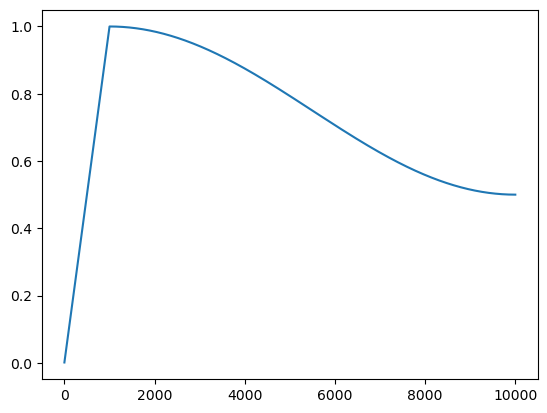

In [21]:
import math
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import AdamW
from accelerate import Accelerator

acc = Accelerator(gradient_accumulation_steps=100)


def get_scheduler(
    optimizer,
    len_dataset,
    batch_size,
    gradient_accumulation_steps,
    epochs,
    min_lr_frac=0.5,
):
    num_steps = math.ceil(len_dataset / batch_size)
    num_steps *= epochs
    warmup_steps = math.ceil(num_steps * 0.1)

    def cosine_decay_with_warmup(step):
        if step < warmup_steps:
            return float(step) / max(1.0, warmup_steps)

        progress = float(step - warmup_steps) / max(1, num_steps - warmup_steps)
        cos_progress = 0.5 * (1 + math.cos(math.pi * progress))
        return cos_progress + (1 - cos_progress) * min_lr_frac

    scheduler = LambdaLR(optimizer, lr_lambda=cosine_decay_with_warmup)

    return scheduler

model = Model()
optimizer = AdamW(model.parameters(), lr=1)
lr_scheduler = get_scheduler(
    optimizer,
    10000,
    10,
    1,
    10,
    min_lr_frac=0.5,
)


lrs = []
for epoch in range(10):
    for batch in range(10000 // 10):
        with acc.accumulate(model):
            lr_scheduler.step()
            lrs.extend(lr_scheduler.get_last_lr())

import matplotlib.pyplot as plt
plt.plot(lrs)
plt.show()

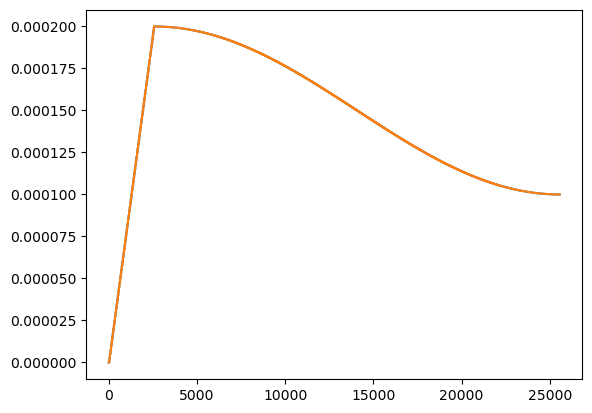

In [28]:
import pickle
with open("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_1/lrs1.pkl", "rb") as f:
    lrs1 = pickle.load(f)

with open("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/audio_upscale_10/stage_1/lrs2.pkl", "rb") as f:
    lrs2 = pickle.load(f)

plt.plot(lrs1)
plt.plot(lrs2)	
plt.show()

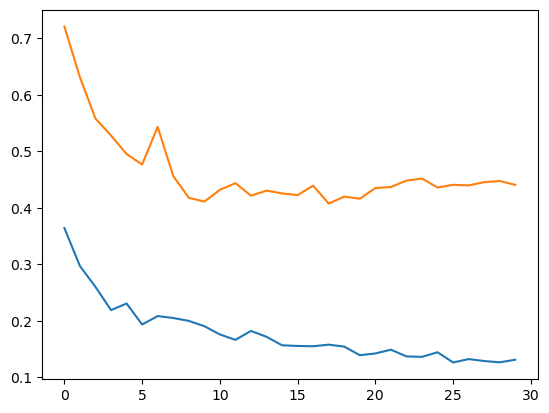

In [1]:
p = "/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/projector_only2/stage_1"
import json
import os
import matplotlib.pyplot as plt

with open(os.path.join(p, "train_losses.json")) as f:
    train_losses = json.load(f)

with open(os.path.join(p, "eval_losses.json")) as f:
    eval_losses = json.load(f)

plt.plot(train_losses)
plt.plot(eval_losses)
plt.show()

In [4]:
import torch
x = torch.load("/home/fock/code/MultiModalInstructERC/experiments/multimodal/mlp/merge/interpolate/iemocap/LLaMA2-base/projector_only2/stage_1/best_model.pth")
x

{'alpha': tensor([1.], device='cuda:0', dtype=torch.bfloat16),
 'projector.proj1.weight': tensor([[-0.0087,  0.0182,  0.0082,  ...,  0.0262, -0.0217, -0.0115],
         [-0.0012,  0.0026,  0.0135,  ..., -0.0138, -0.0012, -0.0239],
         [-0.0173,  0.0147, -0.0173,  ...,  0.0075, -0.0092, -0.0079],
         ...,
         [ 0.0278, -0.0132, -0.0203,  ..., -0.0197,  0.0227,  0.0128],
         [ 0.0187,  0.0330,  0.0148,  ..., -0.0208, -0.0106,  0.0226],
         [ 0.0012,  0.0203, -0.0161,  ...,  0.0016, -0.0128, -0.0147]],
        device='cuda:0', dtype=torch.bfloat16),
 'projector.proj1.bias': tensor([ 0.0193,  0.0142,  0.0337,  ..., -0.0013, -0.0143,  0.0195],
        device='cuda:0', dtype=torch.bfloat16),
 'projector.norm.scale': tensor([1.0078, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 1.0000], device='cuda:0',
        dtype=torch.bfloat16),
 'projector.proj2.weight': tensor([[-0.0210, -0.0258,  0.0251,  ...,  0.0223,  0.0288, -0.0096],
         [ 0.0189, -0.0226, -0.0256,  ...,  0.0

In [11]:
a = torch.nn.Linear(1,1, bias=False)
a.weight = torch.nn.Parameter(torch.tensor([[1.0]]))
next(a.parameters())

b = torch.randn(3, 10)

a(b)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x10 and 1x1)

In [12]:
import deepspeed

a = torch.nn.Parameter(torch.tensor(1.0))
optim = deepspeed.ops.
